In [1]:
# Load the necessary Python packages for the analysis.
%matplotlib inline

import math
import os

import datacube
import geopandas as gpd
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
from datacube.utils.geometry import Geometry
from deafrica_tools.plotting import plot_lulc
from deafrica_tools.spatial import xr_rasterize

In [2]:
# Connect to the datacube to access DE Africa data.
# The `app` parameter is a unique name for the analysis which is based on the notebook file name.
dc = datacube.Datacube(app="Landcover_Reclassification")

In [3]:
# Set important parameters for the analysis.

# Set the bands/measurements of the satellite data to load.
measurements = "classification"

# Set the time period of interest for your analysis.
time_range = ("2014", "2019")

# Set the x and y cell resolution of the satellite data.
# If loading a large area, then increase the resolution so the data will fit into memory.
resolution = (-300, 300)

# Set the Coordinate Reference System (CRS) the satellite data is to be reprojected to.
output_crs = "EPSG:32632"

# Create the output directory to store the results.
output_dir = "results"
os.makedirs(output_dir, exist_ok=True)

In [4]:
# Load the African Countries GeoJSON.
# This file contains polygons for the boundaries of African countries.
african_countries = gpd.read_file("../Supplementary_data/MGCI/african_countries.geojson")

# List the countries in the African Countries GeoJSON.
np.unique(african_countries["COUNTRY"])

array(['Algeria', 'Angola', 'Benin', 'Botswana', 'Burkina Faso',
       'Burundi', 'Cameroon', 'Cape Verde', 'Central African Republic',
       'Chad', 'Comoros', 'Congo-Brazzaville', 'Cote d`Ivoire',
       'Democratic Republic of Congo', 'Djibouti', 'Egypt',
       'Equatorial Guinea', 'Eritrea', 'Ethiopia', 'Gabon', 'Gambia',
       'Ghana', 'Guinea', 'Guinea-Bissau', 'Kenya', 'Lesotho', 'Liberia',
       'Libya', 'Madagascar', 'Malawi', 'Mali', 'Mauritania', 'Morocco',
       'Mozambique', 'Namibia', 'Niger', 'Nigeria', 'Rwanda',
       'Sao Tome and Principe', 'Senegal', 'Sierra Leone', 'Somalia',
       'South Africa', 'Sudan', 'Swaziland', 'Tanzania', 'Togo',
       'Tunisia', 'Uganda', 'Western Sahara', 'Zambia', 'Zimbabwe'],
      dtype=object)

In [5]:
# Select an African country to carry out the analysis over.
country = "Tunisia"

# The country selected needs to be transformed into a geometry object to be used in the dc.load() function.
idx = african_countries[african_countries["COUNTRY"] == country].index[0]
geom = Geometry(geom=african_countries.iloc[idx].geometry, crs=african_countries.crs)

In [6]:
# Create a reusable datacube query object.
query = {
    "geopolygon": geom,
    "time": time_range,
    "measurements": measurements,
    "resolution": resolution,
    "output_crs": output_crs,
}

In [7]:
# Load the ESA Climate Change Initiative Land Cover dataset at 300m resolution.
ds_cci = dc.load(product="cci_landcover", **query)

In [8]:
# Mask the dataset with the country polygon.
african_countries = african_countries.to_crs(output_crs)
mask = xr_rasterize(african_countries[african_countries["COUNTRY"] == country], ds_cci)
ds_cci = ds_cci.where(mask)

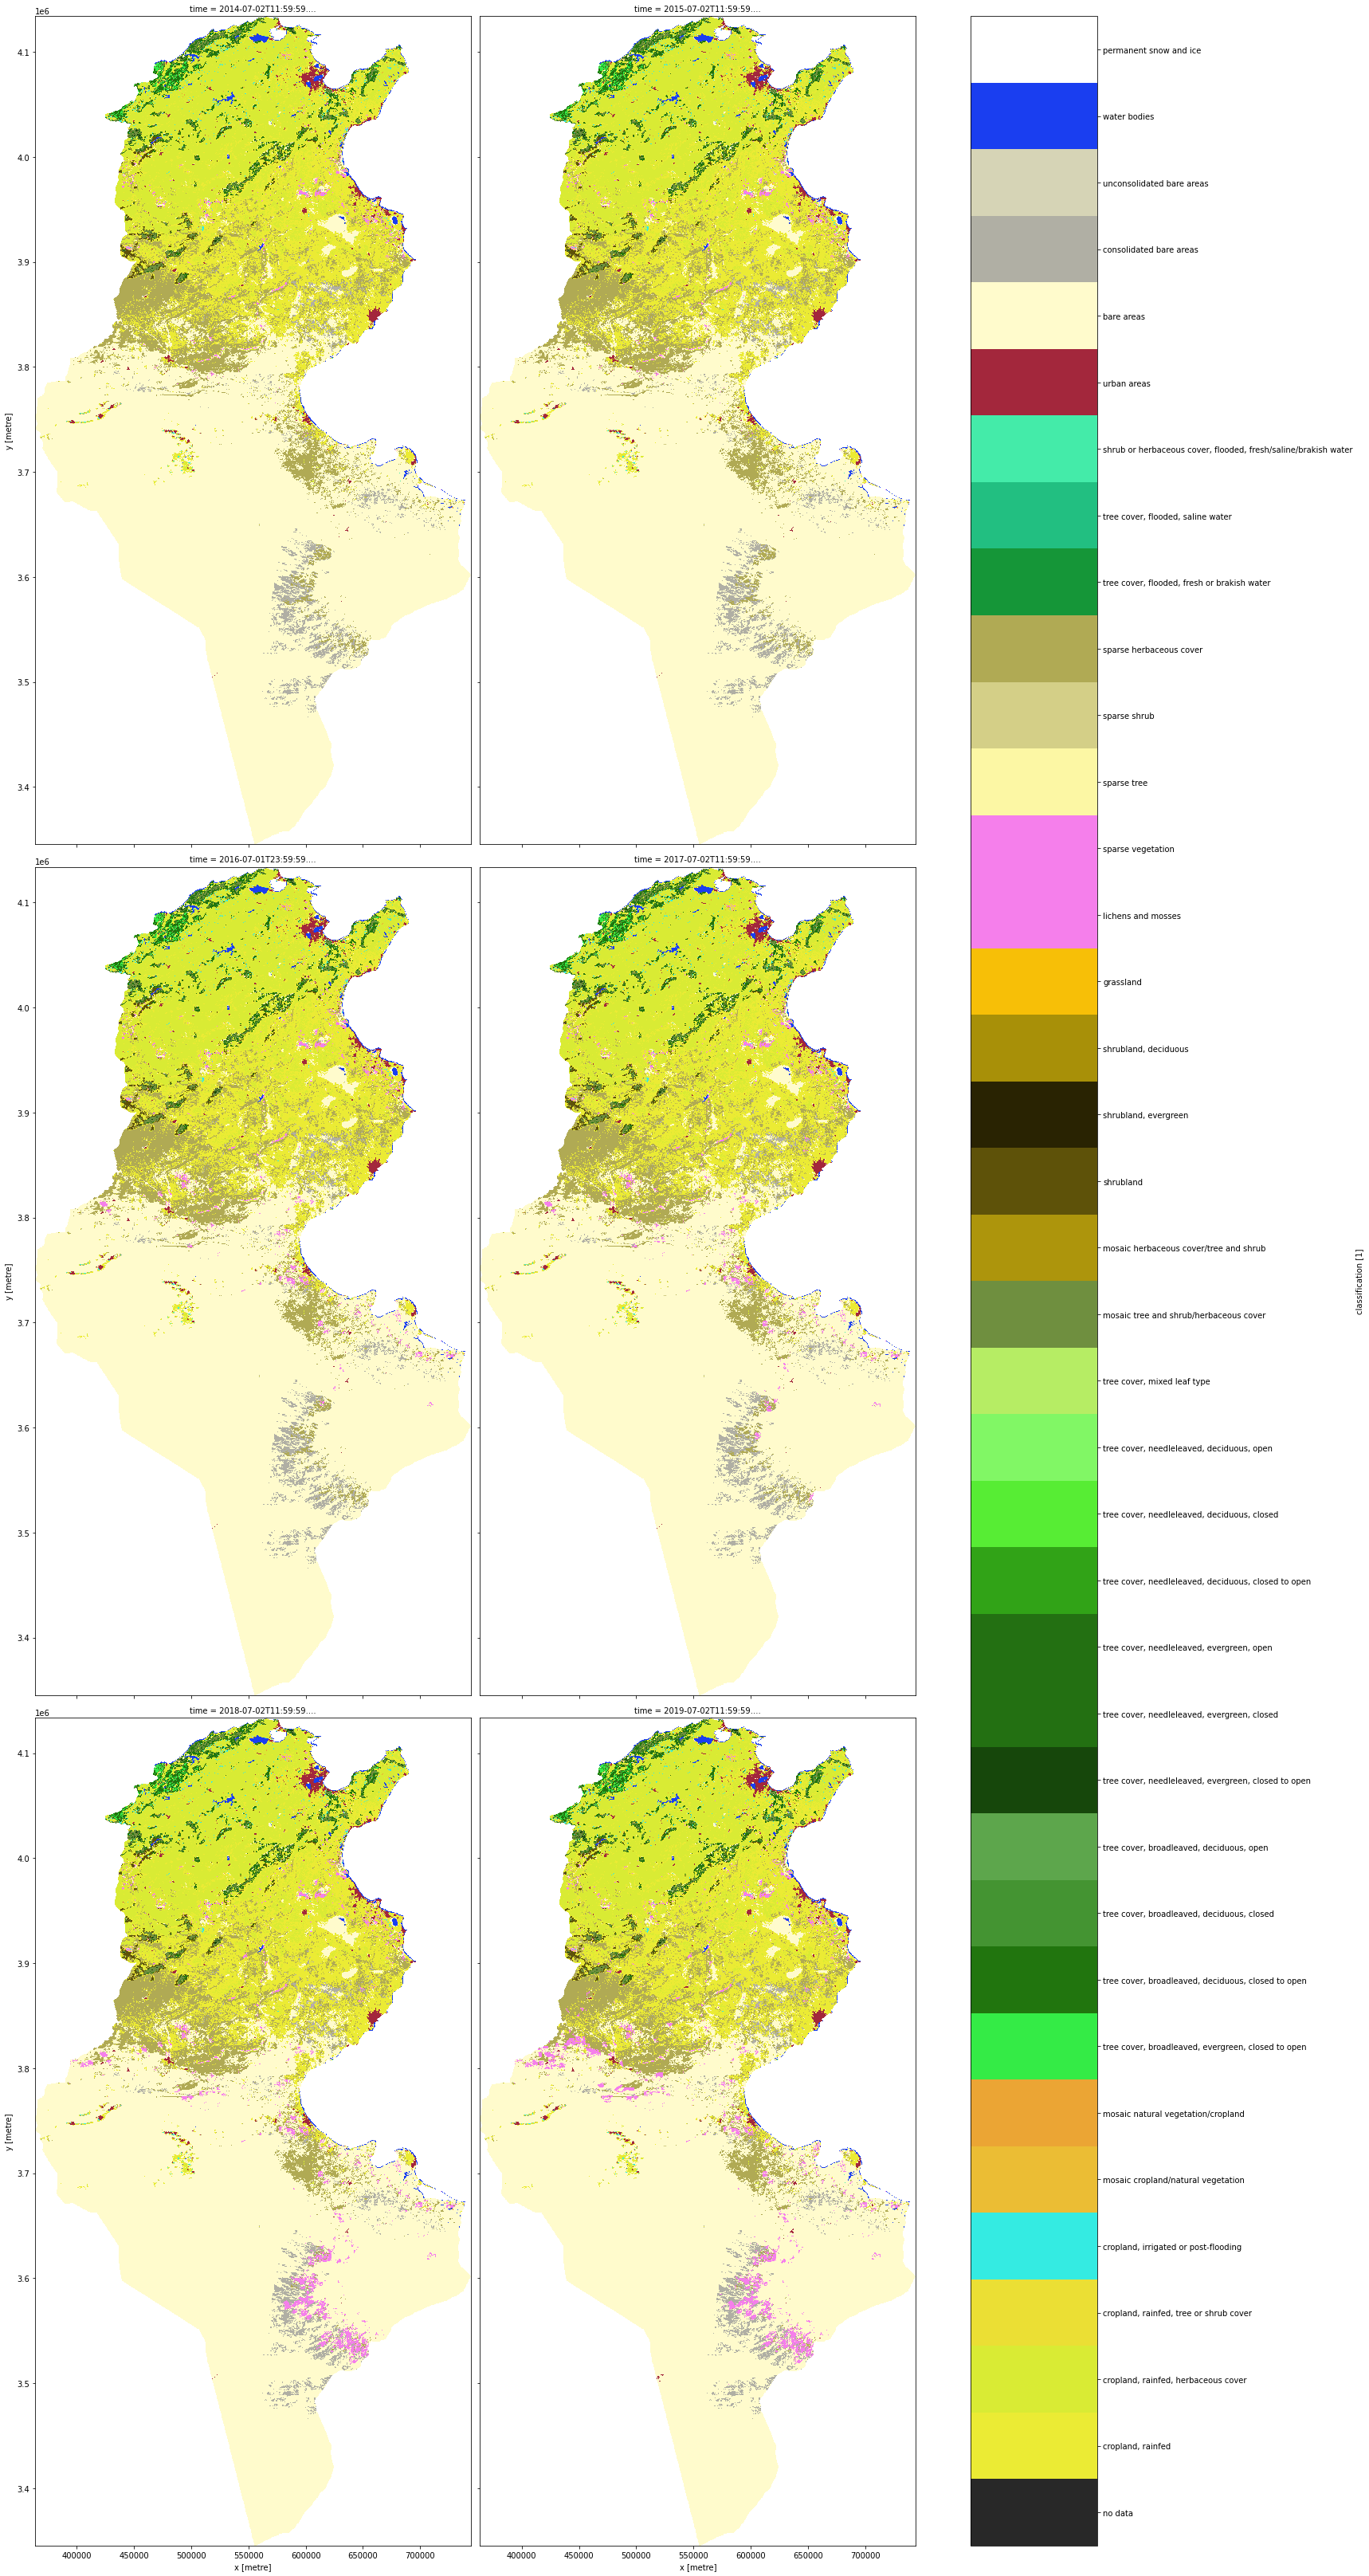

In [9]:
# Plot the CCI Landcover dataset.
plot_lulc(
    ds_cci["classification"], product="CCI", col="time", col_wrap=2, figsize=(20, 45)
);

In [10]:
# Reclassify the CCI land Cover dataset to IPCC Land Cover Classes.

# Define the name and class values of the IPCC Land Cover Classes.
ipcc_classess = [
    "Treed areas",
    "Prairies",
    "Cultivated land",
    "Wetlands",
    "Artificial surfaces",
    "Other lands",
    "Water bodies",
]
ipcc_classess_num = [1, 2, 3, 4, 5, 6, 7]
# Define the colors to be used to represent the IPCC Land Cover Classes when plotting.
# ipcc_classes_colors = ['#16470b', "#f7bf07", '#EBEB34', '#44eba9', '#a3273c', '#d6d4b6', '#1A3EF0']
ipcc_classes_colors = [
    "#054907",
    "#ffa500",
    "#ffff00",
    "#95d0fc",
    "#dc143c",
    "#d6d4b6",
    "#069af3",
]

ds_clas = ds_cci["classification"]
# IPCC Classification
treed_areas = [
    50,
    60,
    61,
    62,
    70,
    71,
    72,
    80,
    81,
    82,
    90,
    100,
    110,
]
priaries = [120, 122, 130, 150, 151, 152, 153]
cultivated_land = [10, 11, 12, 20, 30, 40]
wetlands = [160, 170, 180]
artificial_surfaces = [190]
other_lands = [140, 200, 201, 202, 220]
waterbodies = [210]

ipcc_condition = [
    ds_clas.isin(treed_areas),
    ds_clas.isin(priaries),
    ds_clas.isin(cultivated_land),
    ds_clas.isin(wetlands),
    ds_clas.isin(artificial_surfaces),
    ds_clas.isin(other_lands),
    ds_clas.isin(waterbodies),
]

ds_cci["ipcc_classification"] = (
    xr.DataArray(
        np.select(ipcc_condition, ipcc_classess_num),
        coords={"time": ds_cci.time, "y": ds_cci.y, "x": ds_cci.x},
        dims=["time", "y", "x"],
    )
    .astype("int8")
    .where(mask)
)

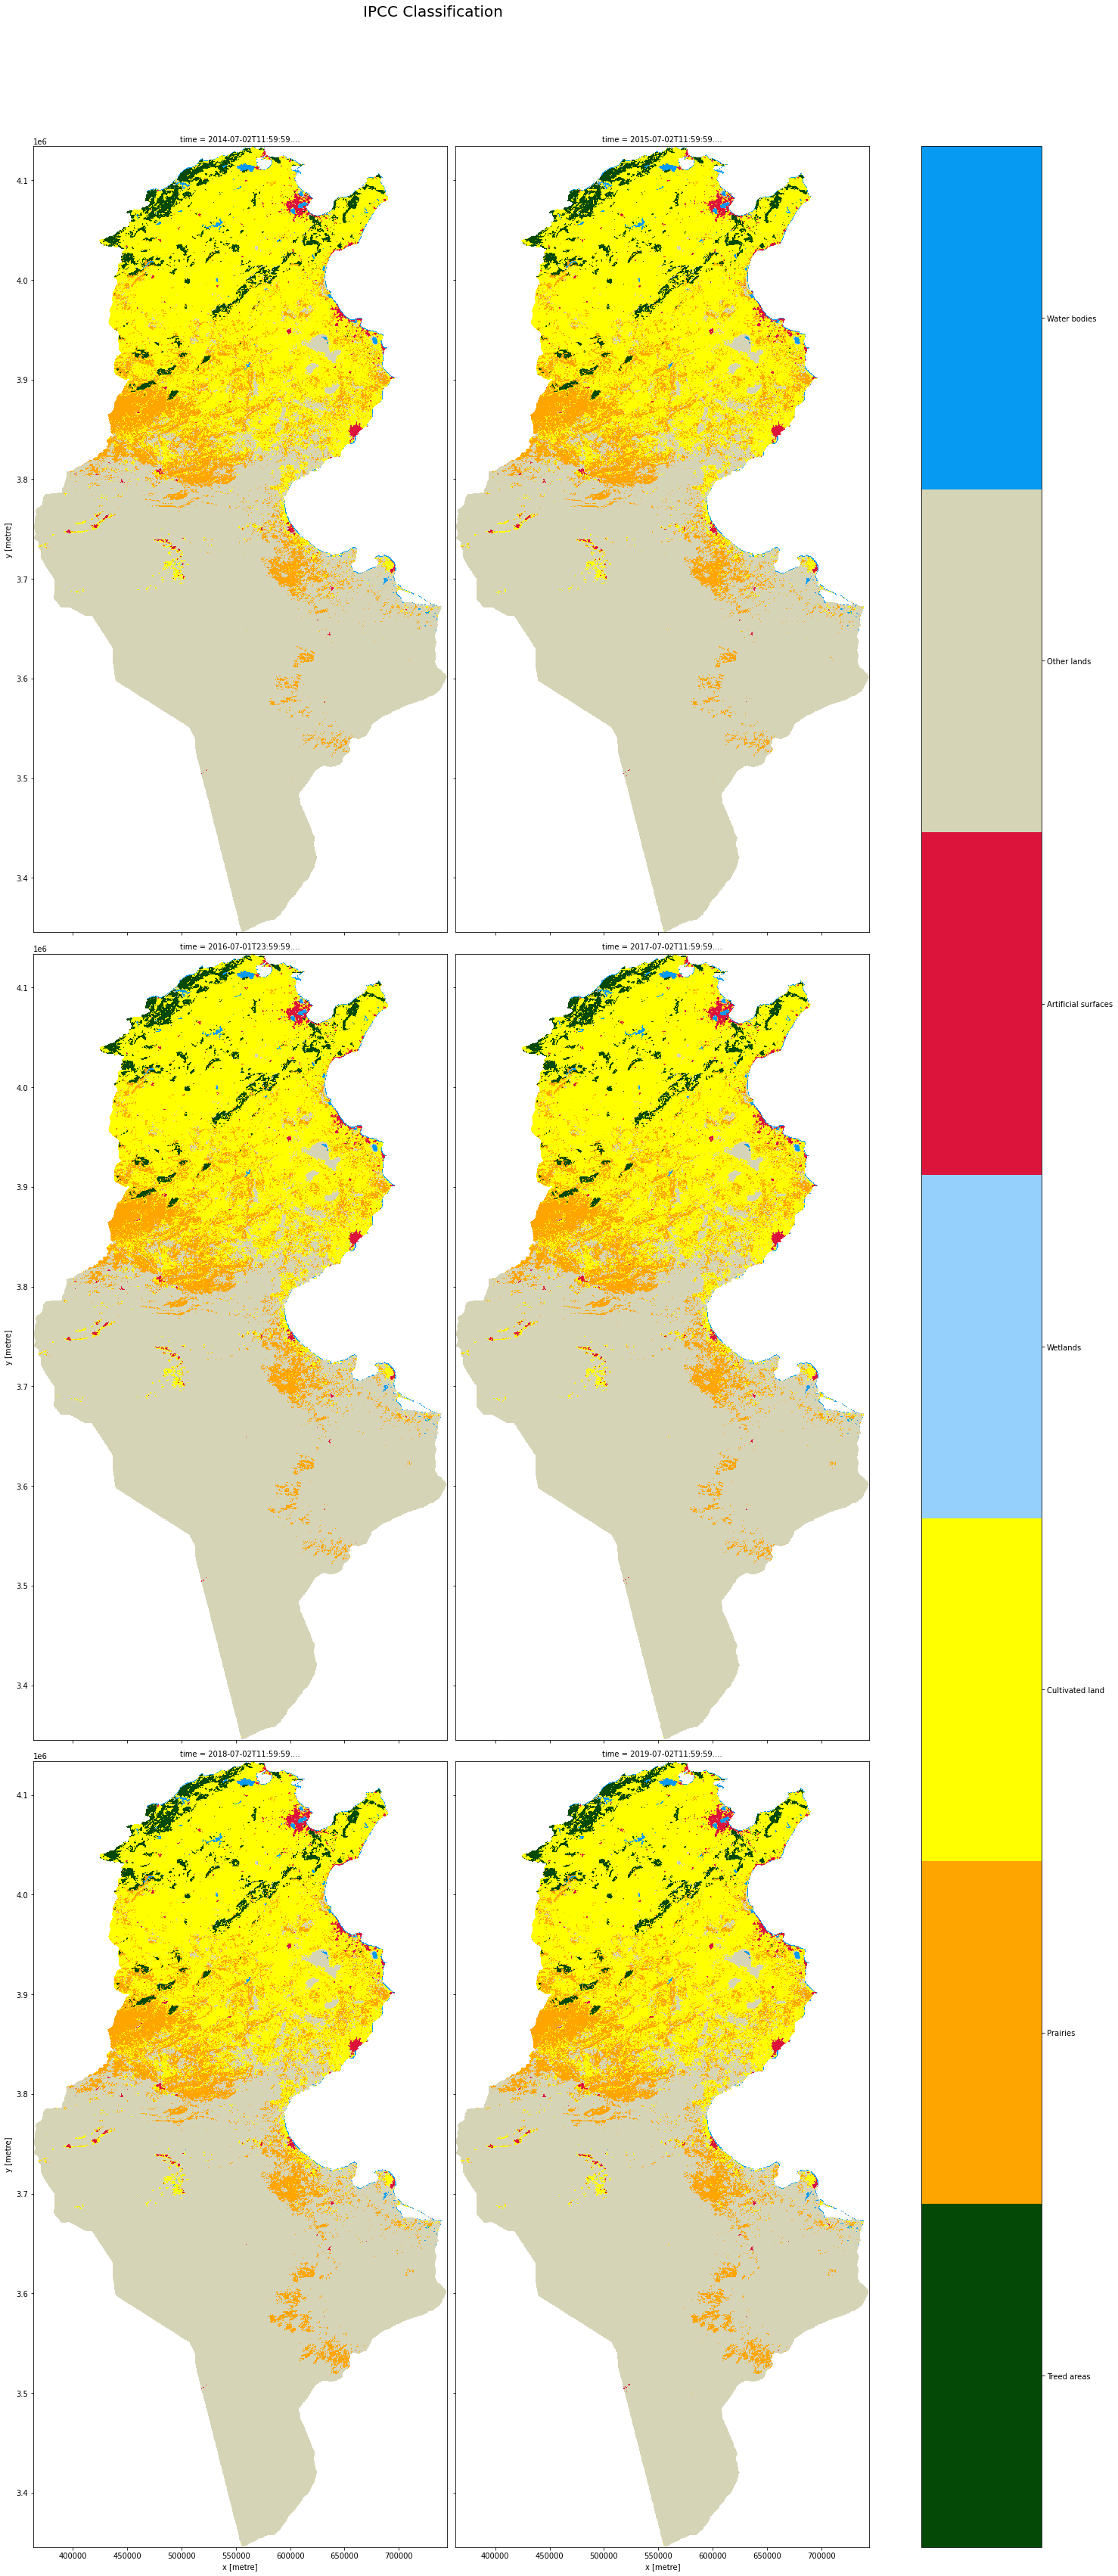

In [11]:
# Define the IPCC Land Cover specific color map.
cmap = mcolors.ListedColormap(colors=ipcc_classes_colors, N=len(ipcc_classess_num))
bounds = np.arange(min(ipcc_classess_num) - 0.5, max(ipcc_classess_num) + 1, 1)
norm = mcolors.BoundaryNorm(bounds, cmap.N)

# Plot the IPCC Land Cover.
clas = ds_cci["ipcc_classification"].plot(
    col="time", col_wrap=2, add_colorbar=False, figsize=(20, 45), cmap=cmap, norm=norm
)

clas.fig.suptitle("IPCC Classification", x=0.4, y=1.05, size=20)
clasp = plt.colorbar(clas._mappables[-1], ax=clas.axes, ticks=ipcc_classess_num)
clasp.set_ticklabels(ipcc_classess)
plt.savefig(f"results/IPCC_{country}")
plt.show()

In [12]:
# Get the resolution i.e. actual ground distance represented by the length of a single pixel in meters.
pixel_length = query["resolution"][1]
# Conversion from metres to kilometres.
m_per_km = 1000
# Get the actual ground area represented by each pixel.
area_per_pixel = (pixel_length / m_per_km) ** 2

In [13]:
# For each year, get the area of each land cover class
# Empty dictionary to store the loop results.
results = {}

# Group the IPCC classification xarray.DataArray by year.
for year, ds_year in ds_cci["ipcc_classification"].groupby("time.year"):
    # Convert the xarray.DataArray to a numpy array.
    ds_np = ds_year.values
    # Use the numpy np.unique function to return the pixel count for each land cover class.
    ds_counts = np.unique(ds_np, return_counts=True)
    # Calculate the area of each land cover class.
    # Remove the last value as it represents the area of pixels with the value np.nan.
    ds_area = np.array(ds_counts[1] * area_per_pixel)[:-1]

    results[year] = dict(zip(ipcc_classess, ds_area))

In [14]:
# Convert the results dictionary into a pandas DataFrame.
results_df = pd.DataFrame.from_dict(results)
results_df.to_csv('results/classification_result.csv')
results_df

,2014,2015,2016,2017,2018,2019
Treed areas,3818.34,3818.25,3829.23,3830.67,3850.47,3861.09
Prairies,14061.24,14060.97,14405.13,14466.24,15235.83,15471.81
Cultivated land,46198.89,46189.26,46165.23,46096.83,46064.16,46054.26
Wetlands,5.13,5.13,5.13,5.13,5.13,5.04
Artificial surfaces,1079.28,1094.31,1094.40,1162.26,1204.29,1237.23
Other lands,88397.82,88393.14,88061.85,87999.84,87201.09,86931.54
Water bodies,842.22,841.86,841.95,841.95,841.95,841.95


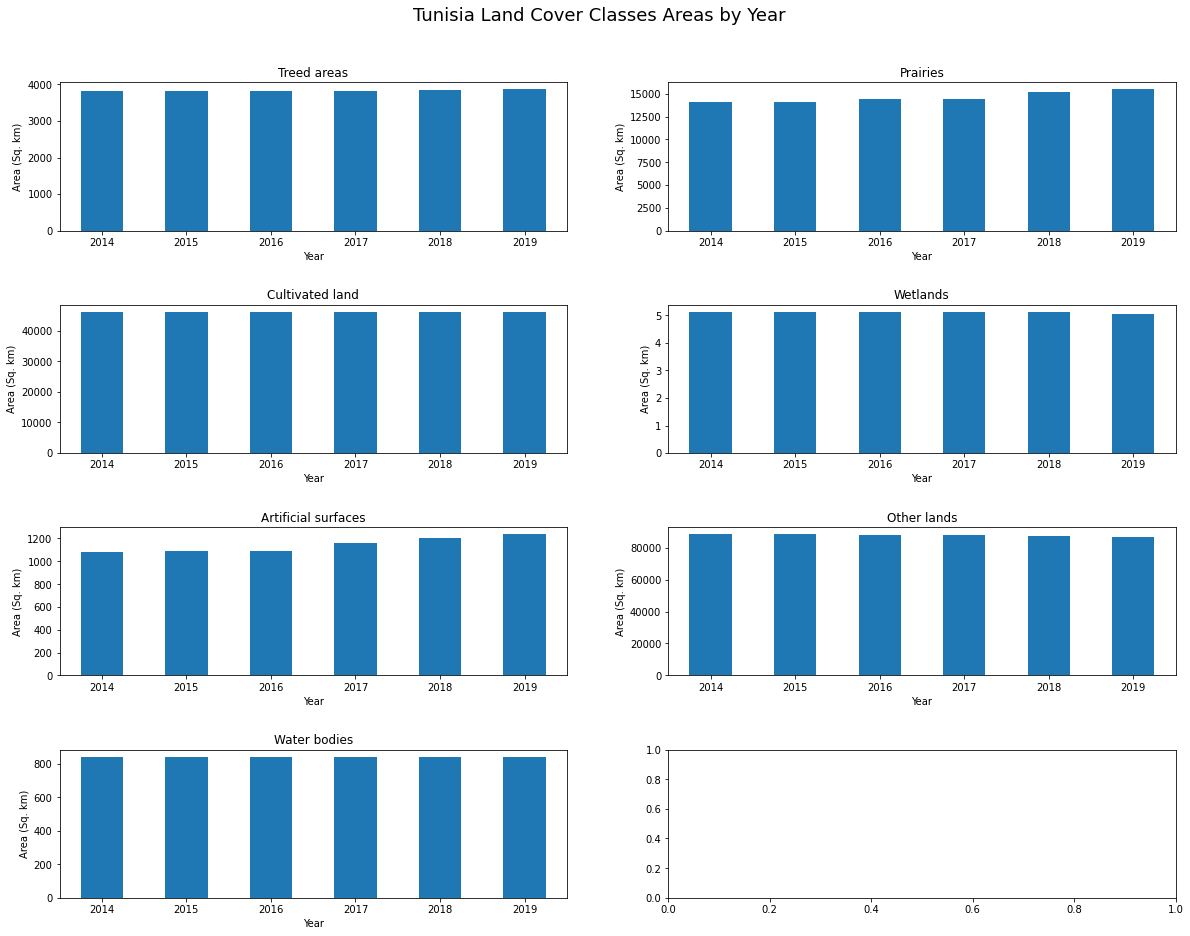

In [15]:
# Plot the area represented by each land cover class over time.

# Transpose the results.df pandas dataframe.
results_df_1 = results_df.T

# Define subplot grid.
ncols = 2
nrows = math.ceil(len(ipcc_classess) / ncols)

fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 15))
plt.subplots_adjust(hspace=0.5)
fig.suptitle(f"{country} Land Cover Classes Areas by Year", fontsize=18, y=0.95)

for i, lulc_class in enumerate(ipcc_classess):
    results_df_1[lulc_class].plot.bar(
        title=f"{lulc_class}",
        xlabel="Year",
        ylabel="Area (Sq. km)",
        rot=0,
        ax=axs.reshape(-1)[i],
    )
    
plt.savefig('results/classification_chart.png')